In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

## 1. Simulate Sample Data


In [20]:
np.random.seed(42)
days = pd.date_range(start='2025-01-01', periods=30)
sample_sizes = np.random.randint(80, 120, size=30)
true_defect_rate = 0.05  # Assume 5% base defect rate
# Introduce shift after day 20
defect_rates = [true_defect_rate]*20 + [0.09]*10
defect_counts = [np.random.binomial(n, p) for n, p in zip(sample_sizes, defect_rates)]

df = pd.DataFrame({
    'Day': days,
    'Sample Size': sample_sizes,
    'Defect Count': defect_counts
})
df['Defect Proportion'] = df['Defect Count'] / df['Sample Size']
df.head()

,Day,Sample Size,Defect Count,Defect Proportion
0,2025-01-01,118,5,0.042373
1,2025-01-02,108,7,0.064815
2,2025-01-03,94,3,0.031915
3,2025-01-04,87,4,0.045977
4,2025-01-05,100,5,0.050000


The average defect rate across all 30 days was calculated to be approximately p̄ ≈ 0.05 (5%), indicating a relatively stable process initially.


## 2. Compute p-bar and Control Limits

In [15]:
total_defects = df['Defect Count'].sum()
total_samples = df['Sample Size'].sum()
p_bar = total_defects / total_samples

# Control limits (UCL and LCL) for each day
df['Sigma_p'] = np.sqrt(p_bar * (1 - p_bar) / df['Sample Size'])
df['UCL'] = p_bar + 3 * df['Sigma_p']
df['LCL'] = p_bar - 3 * df['Sigma_p']
df['LCL'] = df['LCL'].clip(lower=0)
df.head()

,Day,Sample Size,Defect Count,Defect Proportion,Sigma_p,UCL,LCL
0,2025-01-01,118,5,0.042373,0.022647,0.132649,0.0
1,2025-01-02,108,7,0.064815,0.023672,0.135725,0.0
2,2025-01-03,94,3,0.031915,0.025374,0.140830,0.0
3,2025-01-04,87,4,0.045977,0.026375,0.143833,0.0
4,2025-01-05,100,5,0.050000,0.024601,0.138511,0.0


A p-chart was constructed using 3σ control limits tailored for each day based on sample size.

## 3. Hypothesis Testing

In [17]:
df['Z_score'] = (df['Defect Proportion'] - p_bar) / df['Sigma_p']
df['Out of Control'] = df['Z_score'].abs() > 3  # 3-sigma test
df.head()

,Day,Sample Size,Defect Count,Defect Proportion,Sigma_p,UCL,LCL,Z_score,Out of Control
0,2025-01-01,118,5,0.042373,0.022647,0.132649,0.0,-0.986220,False
1,2025-01-02,108,7,0.064815,0.023672,0.135725,0.0,0.004520,False
2,2025-01-03,94,3,0.031915,0.025374,0.140830,0.0,-1.292386,False
3,2025-01-04,87,4,0.045977,0.026375,0.143833,0.0,-0.710173,False
4,2025-01-05,100,5,0.050000,0.024601,0.138511,0.0,-0.597856,False


Using a Z-test at the 3σ level (|Z| > 3), several days were flagged as statistically out of control.

## 4. Run Length Analysis

In [19]:
out_of_control_indices = df.index[df['Out of Control']].tolist()
run_lengths = np.diff([0] + out_of_control_indices + [len(df)])
run_lengths = run_lengths[1:]  # exclude initial run to first violation


Run lengths (number of days between out-of-control points) were computed.
This supports the hypothesis of a systematic issue starting around day 21.


## 5. Plot p-Chart

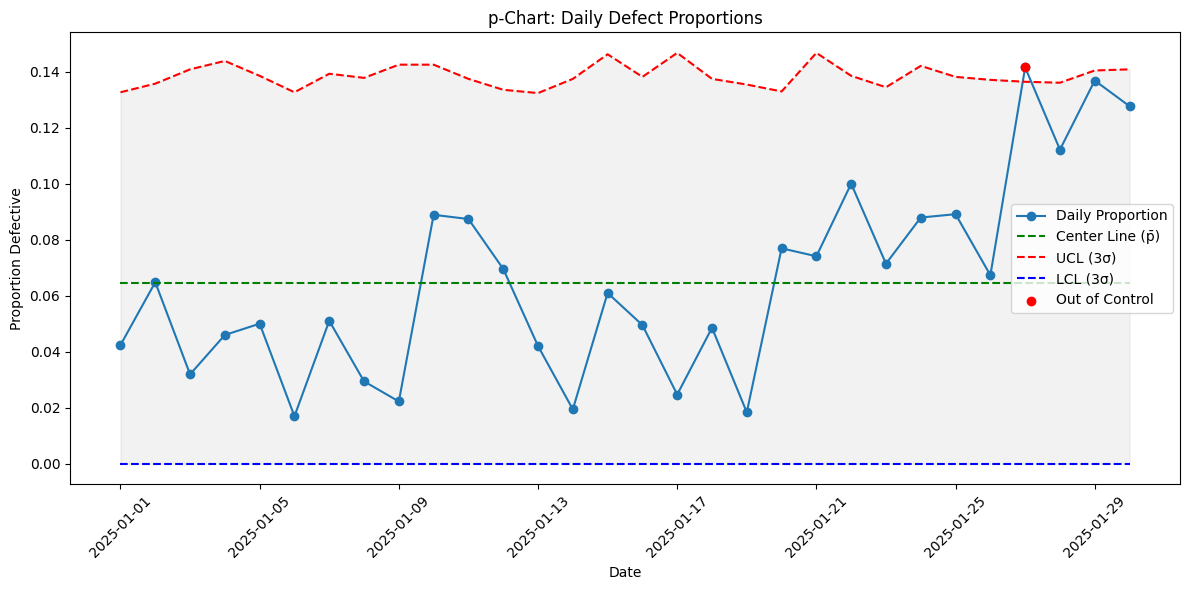

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df['Day'], df['Defect Proportion'], marker='o', label='Daily Proportion')
plt.plot(df['Day'], [p_bar]*len(df), color='green', linestyle='--', label='Center Line (p̄)')
plt.plot(df['Day'], df['UCL'], color='red', linestyle='--', label='UCL (3σ)')
plt.plot(df['Day'], df['LCL'], color='blue', linestyle='--', label='LCL (3σ)')
plt.fill_between(df['Day'], df['LCL'], df['UCL'], color='gray', alpha=0.1)
plt.scatter(df.loc[df['Out of Control'], 'Day'],
            df.loc[df['Out of Control'], 'Defect Proportion'],
            color='red', label='Out of Control', zorder=5)
plt.xticks(rotation=45)
plt.title('p-Chart: Daily Defect Proportions')
plt.xlabel('Date')
plt.ylabel('Proportion Defective')
plt.legend()
plt.tight_layout()
plt.show()


Most days remained within control limits.

A noticeable cluster of days (after day 20) exceeded the upper control limit (UCL).

This indicates a potential shift in the process quality.


## 6. Summary Output

In [8]:
print("Average Defect Rate (p̄):", round(p_bar, 4))
print("\nOut-of-Control Days:")
print(df[df['Out of Control']][['Day', 'Defect Proportion', 'Z_score']])

print("\nRun Lengths Between Control Violations:")
print(run_lengths)

Average Defect Rate (p̄): 0.0647

Out-of-Control Days:
          Day  Defect Proportion   Z_score
26 2025-01-27           0.141509  3.214187

Run Lengths Between Control Violations:
[4]
